In [36]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gplately
import pandas as pd
from matplotlib.gridspec import GridSpec

%matplotlib inline

reconstruction_times = np.arange(0,171)

agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
agegrid_filename = agegrid_dir+"slab_dip/Clennet_AgeGrids_0.1d_masked/seafloor_age_mask_{:.1f}Ma.nc"

In [2]:
# Call GPlately's DataServer from the download.py module
gdownload = gplately.download.DataServer("Clennett2020")

# Obtain all rotation files, topology features and static polygons from Muller et al. 2019
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [3]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
time = 0 #Ma
gplot = gplately.plot.PlotTopologies(model, coastlines, continents, COBs, time=time)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


Read in `training_data.csv` from _stellar-data-mining_ GitHub repository. This CSV contains:

- Training data (from subduction zone kinematics and sampling magnetic, carbon grids, etc.)
- Test data (from Diaz-Rodgriguez et al. 2021 and Hoggard et al. 2020) - includes positive and negative labels
- Unlabelled data from random locations.

> Why are some data with from Diaz-Rodriguez or Hoggard marked as a training set?

In [4]:
df_training = pd.read_csv("../stellar-data-mining/training_data.csv")

Calculate distance to nearest fracture zone for each entry in the training dataset.

In [5]:
age_buffer = 10 # Ma

distances    = np.zeros((df_training.shape[0], age_buffer))
fz_magnitude = np.zeros((df_training.shape[0], age_buffer))

for a in range(0, age_buffer):
    ages  = np.clip(df_training['age (Ma)'] - a, 0, reconstruction_times.max()).astype(int)
    rlons = df_training['lon']
    rlats = df_training['lat']

    with np.load("subducted_fz_data.npz", "r") as npz:
        for i, age in enumerate(ages):
            # extract lon, lat, mag fracture zone data for a given age
            fz_data = npz[str(int(age))]
            fz_lons, fz_lats, fz_mag = fz_data

            # find distance between a reconstructed deposit and fracture zones
            dist = gplately.tools.haversine_distance(rlons[i], fz_lons,
                                                     rlats[i], fz_lats,
                                                     degrees=True)

            # find the minimum distance
            idx_dist = dist.argmin()
            distances[i,a]    = dist[idx_dist]*1e-3
            fz_magnitude[i,a] = fz_mag[idx_dist]

idx_distances = distances.argmin(axis=1)

rows = range(0, df_training.shape[0])
df_training = df_training.assign(distance_to_fz=distances[rows,idx_distances])
df_training = df_training.assign(fz_magnitude=fz_magnitude[rows,idx_distances])


Save to CSV

In [6]:
df_training.to_csv("../stellar-data-mining/training_data_fz.csv", index=False)

Create some CDF plots

In [16]:
def cdf_distance(dist, size):
    idx_sort = dist.argsort()
    dist = dist[idx_sort].copy()
    size = size[idx_sort].copy()
    size /= size.sum()
    cumsum_size = np.cumsum(size)
    return dist, cumsum_size

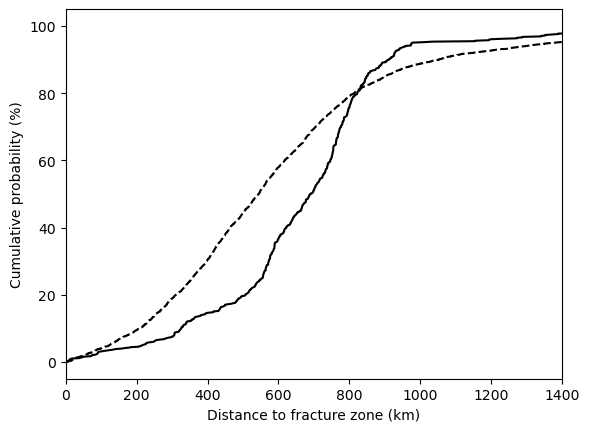

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0,1400])
ax1.set_xlabel('Distance to fracture zone (km)')
ax1.set_ylabel('Cumulative probability (%)')

dist_positive = df_training[df_training['label']=='positive']['distance_to_fz'].to_numpy()
cumsize_positive = np.linspace(0,1,dist_positive.size)

# create cumulative distribution
idx_sort = dist_positive.argsort()
dist_positive = dist_positive[idx_sort]

dist_random = df_training[df_training['label']=='unlabeled']['distance_to_fz'].to_numpy()
cumsize_random = np.linspace(0,1,dist_random.size)

# create cumulative distribution
idx_sort = dist_random.argsort()
dist_random = dist_random[idx_sort]

ax1.plot(dist_positive, cumsize_positive*100, 'k')
ax1.plot(dist_random, cumsize_random*100, 'k--')

# ax1.legend()

In [25]:
def cdf_variable(variable):
    idx_sort = variable.argsort()
    X = variable[idx_sort]
    Y = np.linspace(0, 1, X.size)
    return X,Y

In [26]:
COLUMNS_TO_DROP = {
    "present_lon",
    "present_lat",
    "Cu (Mt)",
    "age (Ma)",
    "plate_id",
    "lon",
    "lat",
    "set",
    "source",
    "overriding_plate_id",
    "subducting_plate_ID",
    "trench_plate_ID",
    "arc_segment_length (degrees)",
    "trench_normal_angle (degrees)",
    "distance_from_trench_start (degrees)",
    "crustal_thickness_n",
    "magnetic_anomaly_n",
}

df_train = df_training.drop(columns=COLUMNS_TO_DROP, errors='ignore')

In [40]:
ncols = 5
nrows = int(np.ceil(df_train.columns.size/5))

gs = GridSpec(nrows, ncols)

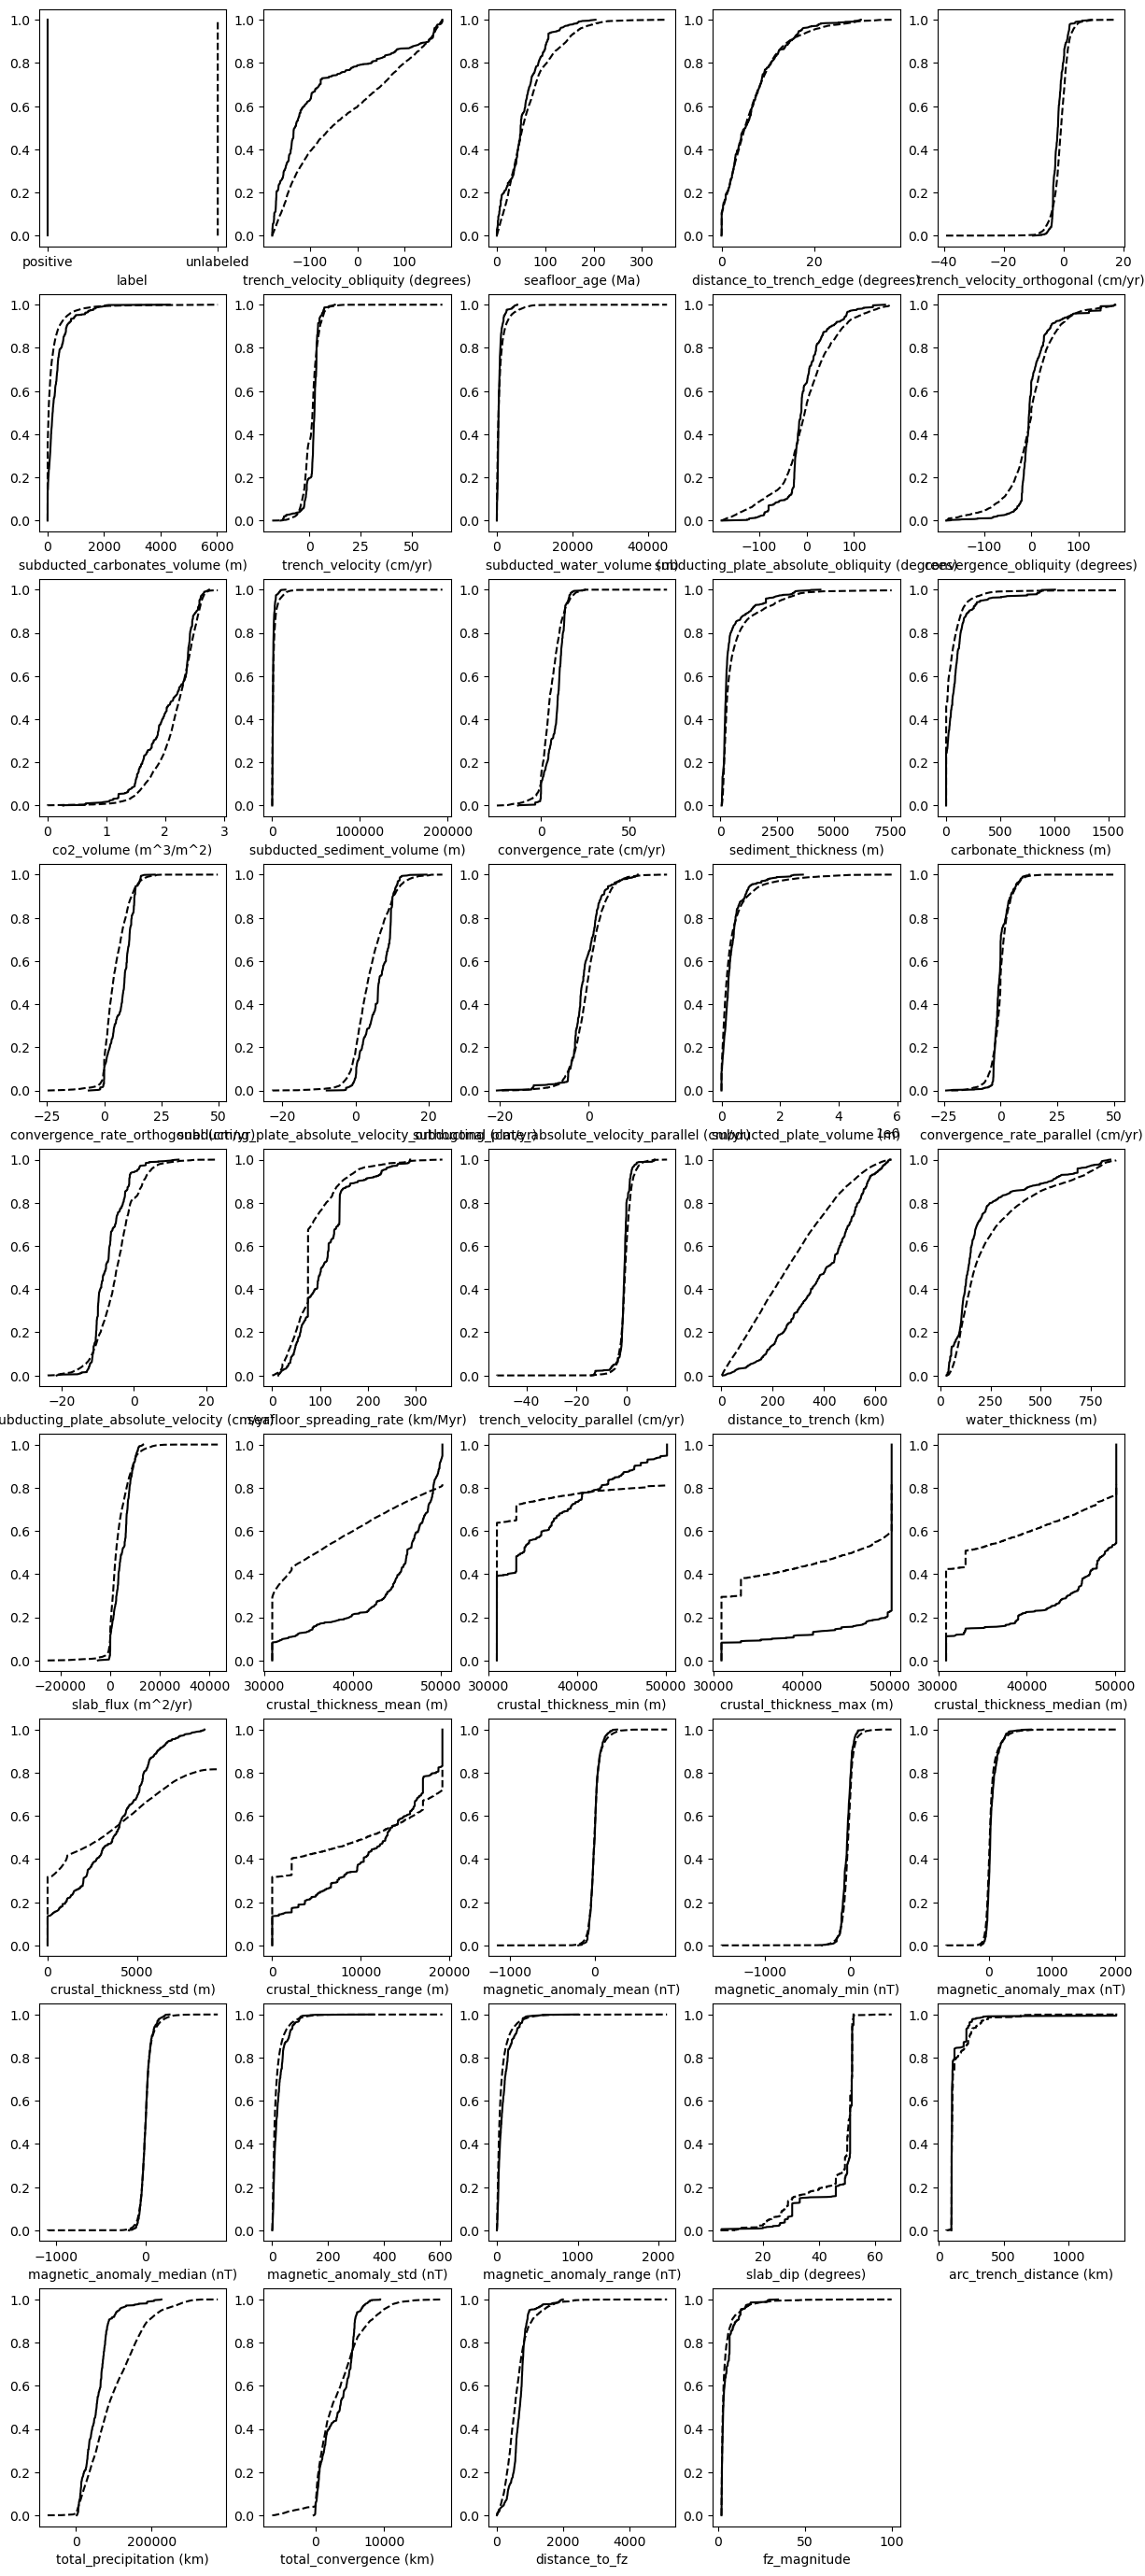

In [46]:
fig = plt.figure(figsize=(15,35))

index = 0

for row in range(0, nrows):
    for col in range(0, ncols):
        if index >= df_train.columns.size:
            break
        
        column = df_train.columns[index]
#         if column == 'label':
#             continue

        ax = fig.add_subplot(gs[row,col], xlabel=column)

        # create CDF
        x_positive, y_positive   = cdf_variable(df_train[df_train['label']=='positive'][column].to_numpy())
        x_unlabeled, y_unlabeled = cdf_variable(df_train[df_train['label']=='unlabeled'][column].to_numpy())
        
        ax.plot(x_positive, y_positive, 'k')
        ax.plot(x_unlabeled, y_unlabeled, 'k--')

        index += 1

plt.show()